In [1]:
import datetime
import time
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.pyplot import ylim
from sklearn import neighbors, svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from operator import itemgetter
from itertools import groupby
import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv('assignment-data/data_for_student_case.csv', dtype={'bin':str, 'amount':int})
df = df.drop(['txid','bookingdate'], axis='columns')
df = df.rename(index=str, columns={'issuercountrycode':'issuercountry', 
                                   'bin':'issuer_id', 
                                   'shoppercountrycode':'shoppercountry', 
                                   'shopperinteraction':'interaction', 
                                   'cardverificationcodesupplied':'verification', 
                                   'cvcresponsecode':'cvcresponse', 
                                   'creationdate':'creationdate_stamp', 
                                   'simple_journal':'label'})

# Skip data if:
df = df[df['label']!='Refused']
df = df[~df['issuer_id'].str.contains('na', case=False)]
df = df[~df['mail_id'].str.contains('na', case=False)]

# Create and format (new) columns
df['issuer_id'] = pd.to_numeric(df['issuer_id'])
df['creationdate'] = (pd.to_datetime(df['creationdate_stamp'])).dt.date
df['mail_id'] = pd.to_numeric(df['mail_id'].str.replace('email','')).astype(int)
df['ip_id'] = pd.to_numeric(df['ip_id'].str.replace('ip','')).astype(int)
df['card_id'] = pd.to_numeric(df['card_id'].str.replace('card','')).astype(int)
df['label'] = pd.to_numeric(df['label'].apply(lambda x: '1' if x == 'Chargeback' else '0'))
df['subscription'] = pd.to_numeric(df['interaction'].apply(lambda x: '1' if x == 'ContAuth' else '0'))
df['verification'] = pd.to_numeric(df['verification'].apply(lambda x: '1' if x else '0'))

countries = pd.concat([df[['issuercountry','amount']].rename(columns = {"issuercountry": "country"}), df[['shoppercountry','amount']].rename(columns = {"shoppercountry": "country"})])
countries = countries.groupby('country')['amount'].agg(['count']).sort_values('count').reset_index()
countries = countries['country'].tolist()
countries_type = pd.api.types.CategoricalDtype(categories=countries)
df['shoppercountry_id'] = df['shoppercountry'].astype(countries_type).cat.codes
df['issuercountry_id'] = df['issuercountry'].astype(countries_type).cat.codes

txvariant = df.groupby('txvariantcode')['amount'].agg(['count']).sort_values('count').reset_index()
txvariant = txvariant['txvariantcode'].tolist()
txvariant_type = pd.api.types.CategoricalDtype(categories=txvariant)
df['txvariant_id'] = df['txvariantcode'].astype(txvariant_type).cat.codes

accounttype = df.groupby('accountcode')['amount'].agg(['count']).sort_values('count').reset_index()
accounttype = accounttype['accountcode'].tolist()
accounttype_type = pd.api.types.CategoricalDtype(categories=accounttype)
df['account_id'] = df['accountcode'].astype(accounttype_type).cat.codes

currency = df.groupby('currencycode')['amount'].agg(['count']).sort_values('count').reset_index()
currency = currency['currencycode'].tolist()
currency_type = pd.api.types.CategoricalDtype(categories=currency)
df['currency_id'] = df['currencycode'].astype(currency_type).cat.codes

print(df.dtypes)

issuercountry         object
txvariantcode         object
issuer_id              int64
amount                 int64
currencycode          object
shoppercountry        object
interaction           object
label                  int64
verification           int64
cvcresponse            int64
creationdate_stamp    object
accountcode           object
mail_id                int64
ip_id                  int64
card_id                int64
creationdate          object
subscription           int64
shoppercountry_id      int16
issuercountry_id       int16
txvariant_id            int8
account_id              int8
currency_id             int8
dtype: object


In [3]:
fraud = df[df['label']==1]
benign = df[df['label']==0]

236698


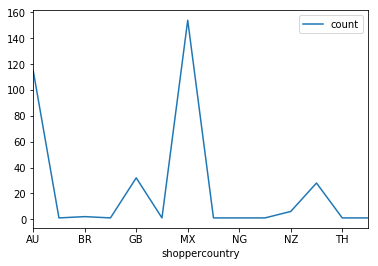

In [4]:
ip = fraud.groupby('shoppercountry')['amount'].agg(['count'])
# print(ip)
# for e in ip:
#     print(e)
ip.plot()

# print(fraud['usd_amount'].describe())
# print(benign['usd_amount'].describe())
# fraud['usd_amount'].plot()


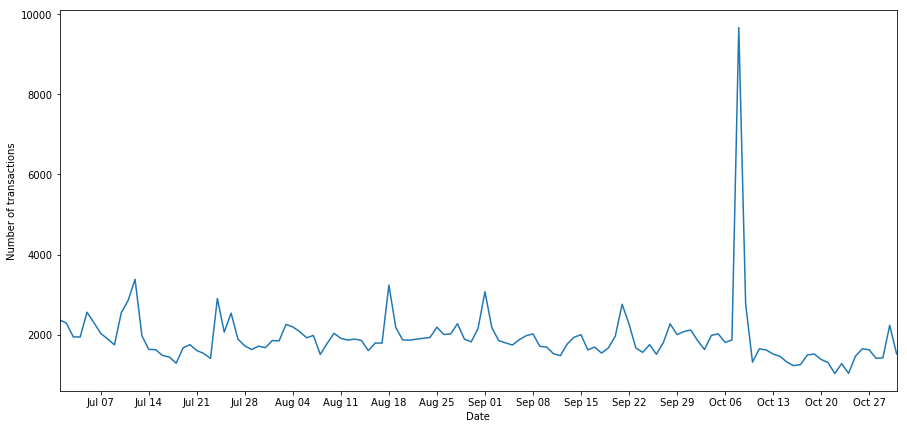

In [5]:
t_day = df.groupby('creationdate')['amount'].agg(['count'])

plt.figure(1, figsize=(15,7))
fig = plt.gcf()
ax = plt.gca()

t_day.plot(ax=ax)
ax.set(xlabel="Date", ylabel="Number of transactions")
ax.xaxis.set_major_locator(mdates.WeekdayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
ax.get_legend().remove()

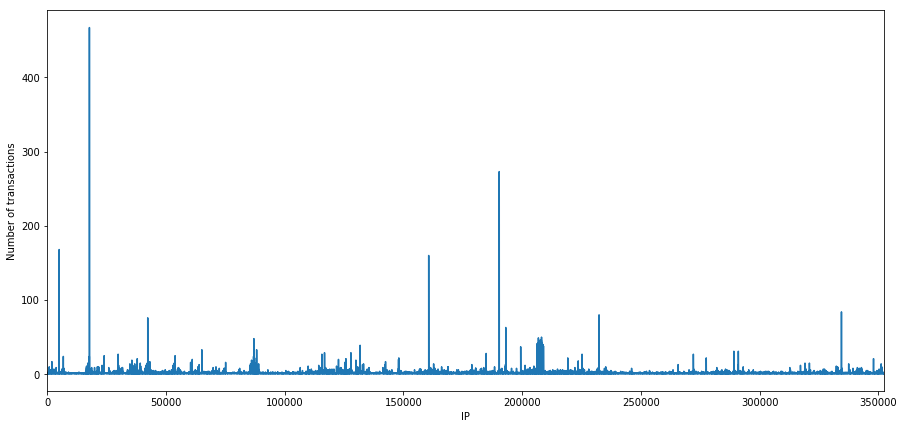

In [6]:
t_ip = df.groupby('ip_id')['amount'].agg(['count'])
t_ip = t_ip.sort_index()

plt.figure(2, figsize=(15,7))
fig = plt.gcf()
ax = plt.gca()

t_ip.plot(ax=ax)
ax.set(xlabel="IP", ylabel="Number of transactions")
ax.get_legend().remove()

In [7]:
c = fraud.groupby('issuercountry')['amount'].agg(['count'])
d = df.groupby('issuercountry')['amount'].agg(['count']).sort_values(['count'])

histogram_intersection = lambda a, b: np.minimum(a, b).sum().round(decimals=2)

df.corr(method='pearson')

,issuer_id,amount,label,verification,cvcresponse,mail_id,ip_id,card_id,subscription,shoppercountry_id,issuercountry_id,txvariant_id,account_id,currency_id
issuer_id,1.000000,0.156597,0.013784,-0.006347,-0.073648,-0.000151,-0.031797,-0.000247,0.006379,-0.016507,-0.020407,-0.151049,-0.200232,-0.161260
amount,0.156597,1.000000,0.078817,0.029003,-0.225500,-0.013983,-0.110045,-0.001291,-0.028957,-0.069786,-0.149294,-0.188099,-0.717575,-0.606371
label,0.013784,0.078817,1.000000,-0.009143,-0.067436,-0.002098,-0.031991,0.000844,0.009156,-0.007228,-0.026181,-0.037863,-0.069959,-0.059979
verification,-0.006347,0.029003,-0.009143,1.000000,0.355075,-0.012821,-0.005367,0.009585,-0.999405,0.009017,-0.007434,0.014461,-0.055205,-0.051322
cvcresponse,-0.073648,-0.225500,-0.067436,0.355075,1.000000,0.004335,0.431935,0.002780,-0.354857,0.055561,0.120289,0.235500,0.538216,0.587358
mail_id,-0.000151,-0.013983,-0.002098,-0.012821,0.004335,1.000000,0.005897,0.001104,0.012857,0.001360,0.004817,-0.003110,0.018303,0.015468
ip_id,-0.031797,-0.110045,-0.031991,-0.005367,0.431935,0.005897,1.000000,0.002490,0.005320,0.079552,0.100457,0.132528,0.277244,0.306943
card_id,-0.000247,-0.001291,0.000844,0.009585,0.002780,0.001104,0.002490,1.000000,-0.009543,-0.003285,0.000149,-0.003987,-0.000958,-0.001300
subscription,0.006379,-0.028957,0.009156,-0.999405,-0.354857,0.012857,0.005320,-0.009543,1.000000,-0.009055,0.007397,-0.014435,0.055137,0.051253
shoppercountry_id,-0.016507,-0.069786,-0.007228,0.009017,0.055561,0.001360,0.079552,-0.003285,-0.009055,1.000000,0.229729,0.058853,0.091254,0.102785


In [ ]:
# If we want to use a all-combiner. This should yield less false positives. 
# from brew.base import Ensemble
# from brew.base import EnsembleClassifier
# from brew.combination.combiner import Combiner

# # create your Ensemble
# clfs = your_list_of_classifiers # [clf1, clf2]
# ens = Ensemble(classifiers = clfs)

# # create your Combiner
# # the rules can be 'majority_vote', 'max', 'min', 'mean' or 'median'
# comb = Combiner(rule='mean')

# # now create your ensemble classifier
# ensemble_clf = EnsembleClassifier(ensemble=ens, combiner=comb)
# ensemble_clf.predict(X)